#  Self Attention

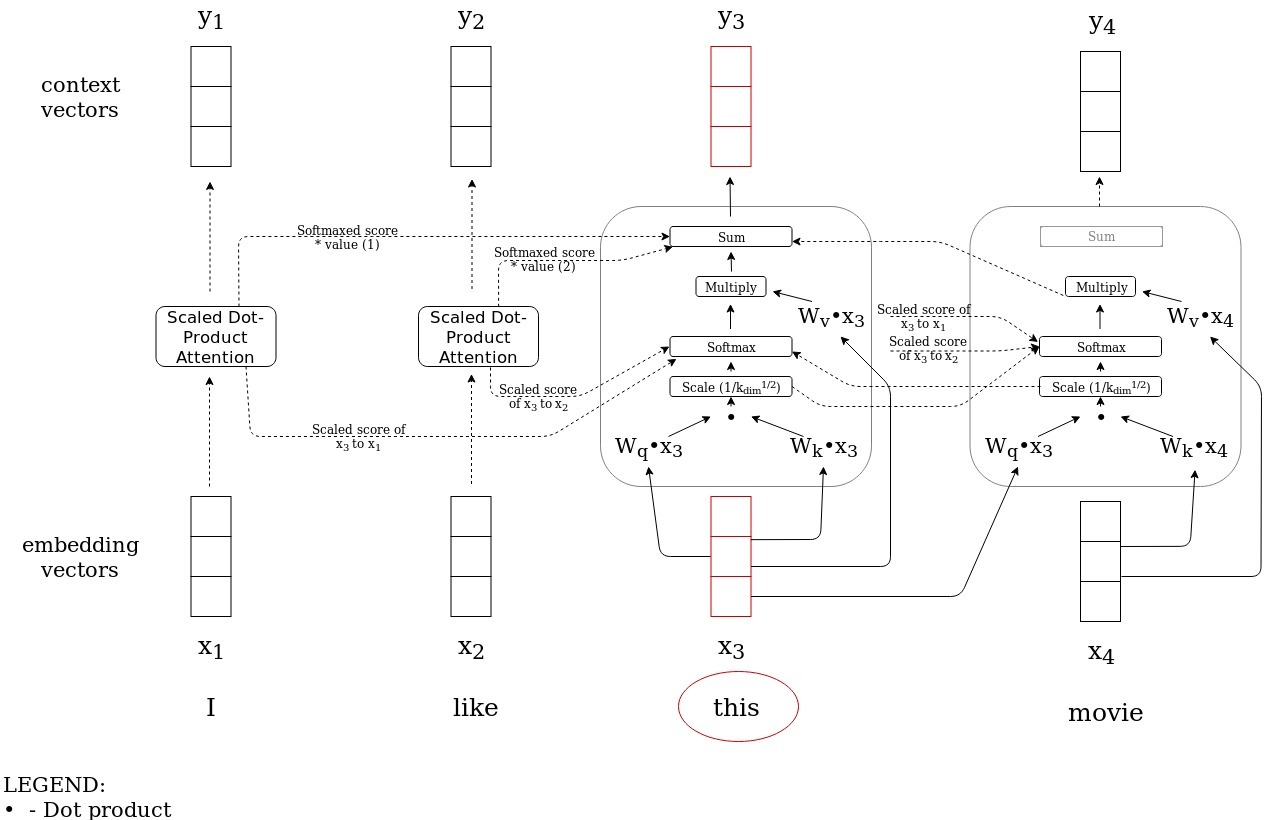

## Multi-Head Attention

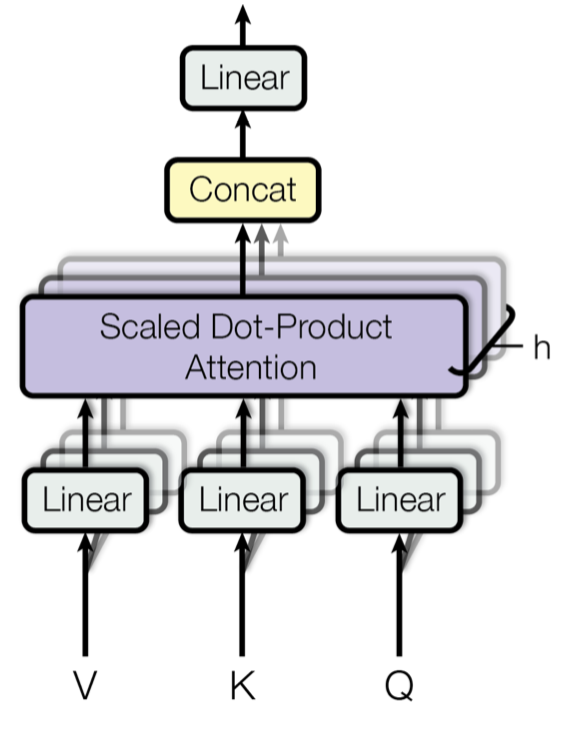

## Positional Encoding

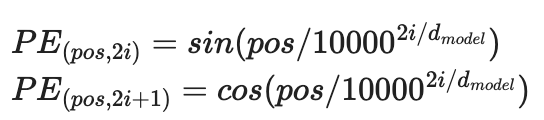

## Label Smoothing

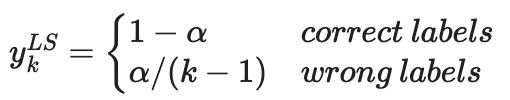

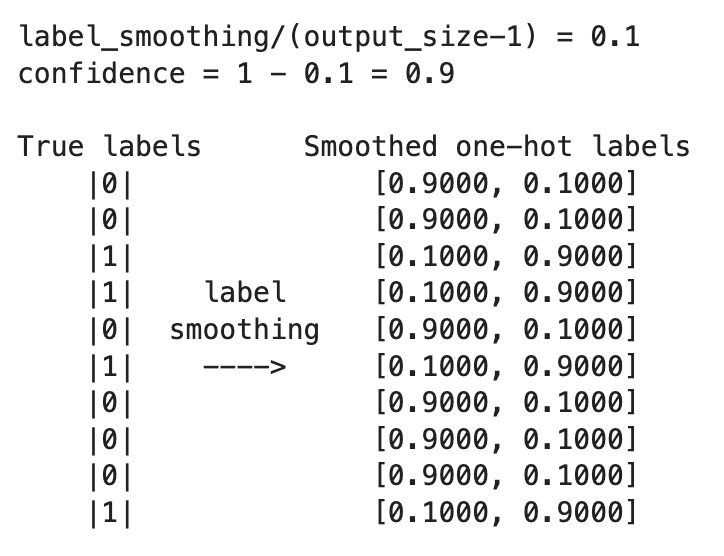

## Transformer Block

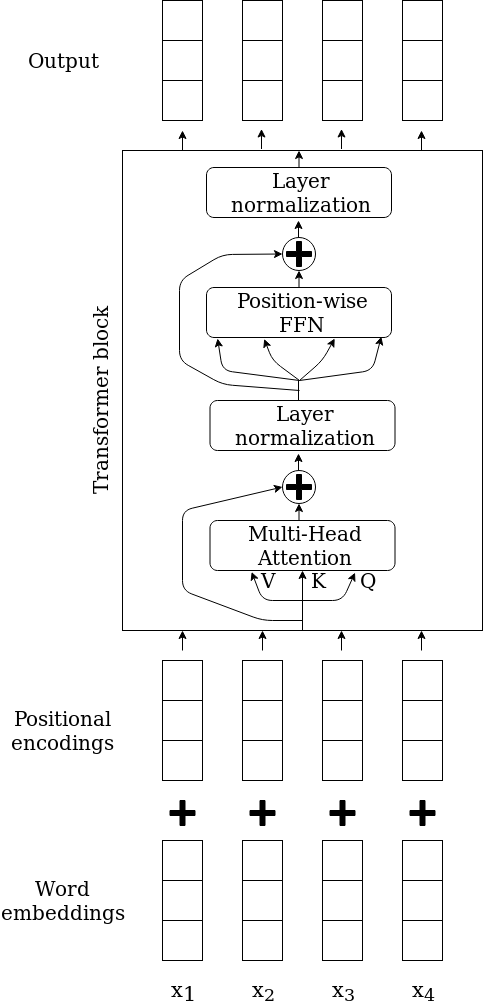

## Transformer for Classfication

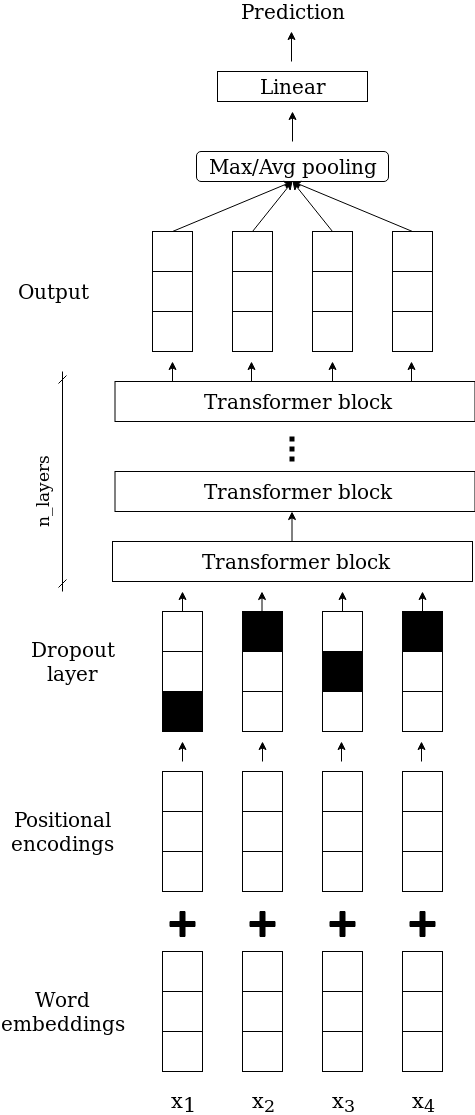

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.7 MB/s eta 0:00:00


In [2]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

# 需要修改文件地址

In [3]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('/content/drive/MyDrive/DT-NLP-2024/Lesson8/train_feat_clean.csv',
                            usecols=['clean_review', 'label'])
train_dataset = train_dataset.dropna(subset=['clean_review'])
# Change columns order
train_dataset = train_dataset[['clean_review', 'label']]

In [4]:
# Depict the first 5 rows of the training set
train_dataset.head()

,clean_review,label
0,movie hotel room entertain children morning le...,0
5,bought £ project vampire worst movies seen woo...,0
7,left movie halfway people liked movie based re...,0
9,best friends brought movie night words wanna w...,0
10,absolutely brilliant season began ended myster...,1


In [5]:

# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('/content/drive/MyDrive/DT-NLP-2024/Lesson8/val_feat_clean.csv',
                          usecols=['clean_review', 'label'])

val_dataset = val_dataset.dropna(subset=['clean_review'])
# Change columns order
val_dataset = val_dataset[['clean_review', 'label']]

In [6]:
# Depict the first 5 rows of the validation set
val_dataset.head()

,clean_review,label
1,felony b movie doubt it.of course look cast li...,0
2,man bogart face sets self viewers nostalgia la...,0
3,old man lives mountains wakes morning loses ca...,1
4,remake fistful dollars sergio leone remake kur...,1
5,film moved age way footage coverage dogtown af...,1


In [7]:
batch_size = 32

In [8]:
train_iterator = BatchIterator(train_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=False, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
45598/145686 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 197
Mapped words to indices
Batches created


In [9]:
val_iterator = BatchIterator(val_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
24831/69602 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 192
Mapped words to indices
Batches created


In [10]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([32, 59])
target shape:  torch.Size([32])
x_lengths shape:  torch.Size([32])


In [11]:
# Extract the maximum sequence length

max_len = 0

for batches in train_iterator:
    x_lengths = batches['x_lengths']
    if max(x_lengths) > max_len:
        max_len = int(max(x_lengths))

In [12]:
print('Maximum sequence length: {}'.format(max_len))

Maximum sequence length: 198


In [13]:
class MultiHeadAttention(nn.Module):
    """Implementation of the Multi-Head-Attention.

    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    heads: int
        Number of the self-attention operations to conduct in parallel.
    """

    def __init__(self, dmodel, heads):

        super(MultiHeadAttention, self).__init__()

        assert dmodel % heads == 0, 'Embedding dimension is not divisible by number of heads'

        self.dmodel = dmodel
        self.heads = heads
        # Split dmodel (embedd dimension) into 'heads' number of chunks
        # each chunk of size key_dim will be passed to different attention head
        self.key_dim = dmodel // heads

        # keys, queries and values will be computed at once for all heads
        # those linear layers will be seperated by Key Query and Value
        self.linear = nn.ModuleList([
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False)])
        # Linear layer for concat the result of the result per head
        self.concat = nn.Linear(self.dmodel, self.dmodel, bias=False)


    def forward(self, inputs):
        """ Perform Multi-Head-Attention.

        Parameters
        ----------
        inputs: torch.Tensor
            Batch of inputs - position encoded word embeddings ((batch_size, seq_length, embedding_dim)

        Returns
        -------
        torch.Tensor
            Multi-Head-Attention output of a shape (batch_size, seq_len, dmodel)
        """

        self.batch_size = inputs.size(0) # size of batch, ususally, the first dimension of inputs is the batch size

        # assert whether the input's third dimensions match the d-model param.
        assert inputs.size(2) == self.dmodel, 'Input sizes mismatch, dmodel={}, while embedd={}'\
            .format(self.dmodel, inputs.size(2))

        # Inputs shape (batch_size, seq_length, embedding_dim)
        # Map input batch allong embedd dimension to query, key and value vectors with
        # a shape of (batch_size, heads, seq_len, key_dim (dmodel // heads))
        # where 'heads' dimension corresponds o different attention head
        query, key, value = [linear(x).view(self.batch_size, -1, self.heads, self.key_dim).transpose(1, 2)\
                             for linear, x in zip(self.linear, (inputs, inputs, inputs))]

        # Calculate the score (batch_size, heads, seq_len, seq_len)
        # for all heads at once
        score = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.key_dim)

        # Apply softmax to scores (batch_size, heads, seq_len, seq_len)
        soft_score = F.softmax(score, dim = -1)

        # Multiply softmaxed score and value vector
        # value input shape (batch_size, heads, seq_len, key_dim)
        # out shape (batch_size, seq_len, dmodel (key_dim * heads))
        out = torch.matmul(soft_score, value).transpose(1, 2).contiguous()\
            .view(self.batch_size, -1, self.heads * self.key_dim)

        # Concatenate and linearly transform heads to the lower dimensional space
        # out shape (batch_size, seq_len, dmodel)
        out = self.concat(out)

        return out


class PositionalEncoding(nn.Module):
    """Implementation of the positional encoding.

    Parameters
    ----------
    max_len: int
        The maximum expected sequence length.
    dmodel: int
        Dimensionality of the input embedding vector.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    padding_idx: int
        Index of the padding token in the vocabulary and word embedding.

    """

    def __init__(self, max_len, dmodel, dropout, padding_idx):

        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)

        # Create pos_encoding, positions and dimensions matrices
        # with a shape of (max_len, dmodel)
        self.pos_encoding = torch.zeros(max_len, dmodel)
        positions = torch.repeat_interleave(torch.arange(float(max_len)).unsqueeze(1), dmodel, dim=1)
        dimensions = torch.arange(float(dmodel)).repeat(max_len, 1)

        # Calculate the encodings trigonometric function argument (max_len, dmodel)
        trig_fn_arg = positions / (torch.pow(10000, 2 * dimensions / dmodel))

        # Encode positions using sin function for even dimensions and
        # cos function for odd dimensions
        self.pos_encoding[:, 0::2] = torch.sin(trig_fn_arg[:, 0::2])
        self.pos_encoding[:, 1::2] = torch.cos(trig_fn_arg[:, 1::2])

        # Set the padding positional encoding to zero tensor
        if padding_idx:
            self.pos_encoding[padding_idx] = 0.0

        # Add batch dimension
        self.pos_encoding = self.pos_encoding.unsqueeze(0)


    def forward(self, embedd):
        """Apply positional encoding.

        Parameters
        ----------
        embedd: torch.Tensor
            Batch of word embeddings ((batch_size, seq_length, dmodel = embedding_dim))

        Returns
        -------
        torch.Tensor
            Sum of word embeddings and positional embeddings (batch_size, seq_length, dmodel)
        """

        # embedd shape (batch_size, seq_length, embedding_dim)
        # pos_encoding shape (1, max_len, dmodel = embedd_dim)
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        embedd = self.dropout(embedd)

        # embedd shape (batch_size, seq_length, embedding_dim)
        return embedd


class LabelSmoothingLoss(nn.Module):
    """Implementation of label smoothing with the Kullback-Leibler divergence Loss.

    Example:
    label_smoothing/(output_size-1) = 0.1
    confidence = 1 - 0.1 = 0.9

    True labels      Smoothed one-hot labels
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
        |1|    label     [0.1000, 0.9000]
        |0|  smoothing   [0.9000, 0.1000]
        |1|    ---->     [0.1000, 0.9000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]

    Parameters
    ----------
    output_size: int
         The number of classes.
    label_smoothing: float, optional (default=0)
        The smoothing parameter. Takes the value in range [0,1].

    """

    def __init__(self, output_size, label_smoothing=0):

        super(LabelSmoothingLoss, self).__init__()

        self.output_size = output_size
        self.label_smoothing = label_smoothing
        self.confidence = 1 - self.label_smoothing

        assert label_smoothing >= 0.0 and label_smoothing <= 1.0, \
        'Label smoothing parameter takes values in the range [0, 1]'

        self.criterion = nn.KLDivLoss()


    def forward(self, pred, target):
        """Smooth the target labels and calculate the Kullback-Leibler divergence loss.

        Parameters
        ----------
        pred: torch.Tensor
            Batch of log-probabilities (batch_size, output_size)
        target: torch.Tensor
            Batch of target labels (batch_size, seq_length)

        Returns
        -------
        torch.Tensor
            The Kullback-Leibler divergence Loss.

        """
        # Create a Tensor of targets probabilities of a shape that equals 'pred' dimensions, filled all
        # with label_smoothing/(output_size-1) value that will correspond to the wrong label probability.
        one_hot_probs = torch.full(size=pred.size(), fill_value=self.label_smoothing/(self.output_size - 1))

        # Fill the tensor at positions that correspond to the true label from the target vector (0/1)
        # with the modified value of maximum probability (confidence).
        one_hot_probs.scatter_(1, target.unsqueeze(1), self.confidence)

        # KLDivLoss takes inputs (pred) that contain log-probs and targets given as probs (one_hot_probs).
        return self.criterion(pred, one_hot_probs)

In [15]:
class TransformerBlock(nn.Module):
    """Implementation of single Transformer block.

    Transformer block structure:
    x --> Multi-Head --> Layer normalization --> Pos-Wise FFNN --> Layer normalization --> y
      |   Attention   |                       |                 |
      |_______________|                       |_________________|
     residual connection                      residual connection

    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    ffnn_hidden_size: int
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int
        Number of the self-attention operations to conduct in parallel.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    """

    def __init__(self, dmodel, ffnn_hidden_size, heads, dropout):

        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(dmodel, heads)
        self.layer_norm1 = nn.LayerNorm(dmodel)
        self.layer_norm2 = nn.LayerNorm(dmodel)

        self.ffnn = nn.Sequential(
                nn.Linear(dmodel, ffnn_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ffnn_hidden_size, dmodel))


    def forward(self, inputs):
        """Forward propagate through the Transformer block.

        Parameters
        ----------
        inputs: torch.Tensor
            Batch of embeddings.

        Returns
        -------
        torch.Tensor
            Output of the Transformer block (batch_size, seq_length, dmodel)
        """
        # Inputs shape (batch_size, seq_length, embedding_dim = dmodel)
        output = inputs + self.attention(inputs)
        output = self.layer_norm1(output)
        output = output + self.ffnn(output)
        output = self.layer_norm2(output)

        # Output shape (batch_size, seq_length, dmodel)
        return output


class Transformer(nn.Module):
    """Implementation of the Transformer model for classification.

    Parameters
    ----------
    vocab_size: int
        The size of the vocabulary.
    dmodel: int
        Dimensionality of the embedding vector.
    max_len: int
        The maximum expected sequence length.
    padding_idx: int, optional (default=0)
        Index of the padding token in the vocabulary and word embedding.
    n_layers: int, optional (default=4)
        Number of the stacked Transformer blocks.
    ffnn_hidden_size: int, optonal (default=dmodel * 4)
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int, optional (default=8)
        Number of the self-attention operations to conduct in parallel.
    pooling: str, optional (default='max')
        Specify the type of pooling to use. Available options: 'max' or 'avg'.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    """

    def __init__(self, vocab_size, dmodel, output_size, max_len, padding_idx=0, n_layers=4,
                 ffnn_hidden_size=None, heads=8, pooling='max', dropout=0.2):

        super(Transformer, self).__init__()

        if not ffnn_hidden_size:
            ffnn_hidden_size = dmodel * 4

        assert pooling == 'max' or pooling == 'avg', 'Improper pooling type was passed.'

        self.pooling = pooling
        self.output_size = output_size

        self.embedding = nn.Embedding(vocab_size, dmodel)

        self.pos_encoding = PositionalEncoding(max_len, dmodel, dropout, padding_idx)

        self.tnf_blocks = nn.ModuleList()

        for n in range(n_layers):
            self.tnf_blocks.append(
                TransformerBlock(dmodel, ffnn_hidden_size, heads, dropout))

        self.tnf_blocks = nn.Sequential(*self.tnf_blocks)

        self.linear = nn.Linear(dmodel, output_size)


    def forward(self, inputs, input_lengths):
        """Forward propagate through the Transformer.

        Parameters
        ----------
        inputs: torch.Tensor
            Batch of input sequences.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.

        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed class tensor.
        """
        self.batch_size = inputs.size(0)

        # Input dimensions (batch_size, seq_length, dmodel)
        output = self.embedding(inputs)
        output = self.pos_encoding(output)
        output = self.tnf_blocks(output)
        # Output dimensions (batch_size, seq_length, dmodel)

        if self.pooling == 'max':
            # Permute to the shape (batch_size, dmodel, seq_length)
            # Apply max-pooling, output dimensions (batch_size, dmodel)
            output = F.adaptive_max_pool1d(output.permute(0,2,1), (1,)).view(self.batch_size,-1)
        else:
            # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
            # Output shape: (batch_size, dmodel)
            output = torch.sum(output, dim=1) / input_lengths.view(-1,1).type(torch.FloatTensor)

        output = self.linear(output)

        return F.log_softmax(output, dim=-1)


    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.

        """
        self.loss_fn = loss_fn


    def add_optimizer(self, optimizer):
        """Add optimizer to the model.

        """
        self.optimizer = optimizer


    def add_device(self, device=torch.device('cpu')):
        """Specify the device.

        """
        self.device = device


    def train_model(self, train_iterator):
        """Perform single training epoch.

        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.

        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.

        """
        self.train()

        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0

        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']

            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)

            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()

            losses_list.append(loss.data.cpu().numpy())

            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)

            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)

                accuracy = batch_correct / num_seq

                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))

                losses = []

            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq

        return train_losses, avg_loss, accuracy


    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.

        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.

        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.

        """
        self.eval()

        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()

        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']

                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())

                pred = torch.argmax(pred, 1)

                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()

                else:
                    batch_correct += (pred == target).sum().item()

                num_seq += len(input_seq)

                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)

                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)

                    accuracy = batch_correct / num_seq

                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []

            avg_loss_list = []

            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq

            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))

        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)

        return eval_losses, avg_loss, accuracy, conf_matrix

In [16]:
# Initialize parameters
vocab_size = len(train_iterator.word2index)
dmodel = 64
output_size = 2
padding_idx = train_iterator.word2index['<PAD>']
n_layers = 4
ffnn_hidden_size = dmodel * 2
heads = 8
pooling = 'max'
dropout = 0.5
label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = Transformer(vocab_size, dmodel, output_size, max_len, padding_idx, n_layers,\
                    ffnn_hidden_size, heads, pooling, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

# Add loss function
if label_smoothing:
    loss_fn = LabelSmoothingLoss(output_size, label_smoothing)
else:
    loss_fn = nn.NLLLoss()

model.add_loss_fn(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Create the parameters dictionary and instantiate the tensorboardX SummaryWriter
params = {'batch_size': batch_size,
          'dmodel': dmodel,
          'n_layers': n_layers,
          'ffnn_hidden_size': ffnn_hidden_size,
          'heads': heads,
          'pooling': pooling,
          'dropout': dropout,
          'label_smoothing': label_smoothing,
          'learning_rate': learning_rate}

train_writer = SummaryWriter(comment=f' Training, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

val_writer = SummaryWriter(comment=f' Validation, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):

    try:
        print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))

        train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)

        train_losses_list.append(train_losses)
        train_avg_loss_list.append(train_avg_loss)
        train_accuracy_list.append(train_accuracy)

        _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)

        eval_avg_loss_list.append(eval_avg_loss)
        eval_accuracy_list.append(eval_accuracy)
        conf_matrix_list.append(conf_matrix)

        print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
              .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))

        train_writer.add_scalar('Training loss', train_avg_loss, epoch)
        val_writer.add_scalar('Validation loss', eval_avg_loss, epoch)

        if early_stop.stop(eval_avg_loss, model, delta=0.003):
            break

    finally:
        train_writer.close()
        val_writer.close()


Start epoch [1/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1902. Accuracy: 0.512
Iteration: 200. Average training loss: 0.1874. Accuracy: 0.503
Iteration: 300. Average training loss: 0.1784. Accuracy: 0.525
Iteration: 400. Average training loss: 0.1725. Accuracy: 0.546
Iteration: 500. Average training loss: 0.1634. Accuracy: 0.566
Iteration: 600. Average training loss: 0.1542. Accuracy: 0.585
Iteration: 700. Average training loss: 0.1515. Accuracy: 0.601
Iteration: 800. Average training loss: 0.1443. Accuracy: 0.616
Iteration: 900. Average training loss: 0.1370. Accuracy: 0.629
Iteration: 1000. Average training loss: 0.1370. Accuracy: 0.640


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1133. Accuracy: 0.79
Iteration: 200. Average evaluation loss: 0.1164. Accuracy: 0.78
Iteration: 300. Average evaluation loss: 0.1160. Accuracy: 0.78

Epoch [1/30]: Train accuracy: 0.648. Train loss: 0.1593. Evaluation accuracy: 0.782. Evaluation loss: 0.1149

Start epoch [2/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1358. Accuracy: 0.729
Iteration: 200. Average training loss: 0.1325. Accuracy: 0.736
Iteration: 300. Average training loss: 0.1243. Accuracy: 0.743
Iteration: 400. Average training loss: 0.1192. Accuracy: 0.751
Iteration: 500. Average training loss: 0.1154. Accuracy: 0.757
Iteration: 600. Average training loss: 0.1133. Accuracy: 0.762
Iteration: 700. Average training loss: 0.1154. Accuracy: 0.765
Iteration: 800. Average training loss: 0.1111. Accuracy: 0.767
Iteration: 900. Average training loss: 0.1042. Accuracy: 0.771
Iteration: 1000. Average training loss: 0.1075. Accuracy: 0.774


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0986. Accuracy: 0.82
Iteration: 200. Average evaluation loss: 0.0986. Accuracy: 0.82
Iteration: 300. Average evaluation loss: 0.1002. Accuracy: 0.82

Epoch [2/30]: Train accuracy: 0.776. Train loss: 0.1170. Evaluation accuracy: 0.823. Evaluation loss: 0.0989

Start epoch [3/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1069. Accuracy: 0.800
Iteration: 200. Average training loss: 0.1031. Accuracy: 0.801
Iteration: 300. Average training loss: 0.1016. Accuracy: 0.807
Iteration: 400. Average training loss: 0.0977. Accuracy: 0.813
Iteration: 500. Average training loss: 0.0977. Accuracy: 0.815
Iteration: 600. Average training loss: 0.0975. Accuracy: 0.817
Iteration: 700. Average training loss: 0.0914. Accuracy: 0.820
Iteration: 800. Average training loss: 0.0926. Accuracy: 0.821
Iteration: 900. Average training loss: 0.0893. Accuracy: 0.823
Iteration: 1000. Average training loss: 0.0917. Accuracy: 0.824


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0834. Accuracy: 0.85
Iteration: 200. Average evaluation loss: 0.0831. Accuracy: 0.85
Iteration: 300. Average evaluation loss: 0.0876. Accuracy: 0.85

Epoch [3/30]: Train accuracy: 0.825. Train loss: 0.0964. Evaluation accuracy: 0.852. Evaluation loss: 0.0843

Start epoch [4/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0915. Accuracy: 0.835
Iteration: 200. Average training loss: 0.0889. Accuracy: 0.838
Iteration: 300. Average training loss: 0.0875. Accuracy: 0.841
Iteration: 400. Average training loss: 0.0880. Accuracy: 0.842
Iteration: 500. Average training loss: 0.0810. Accuracy: 0.846
Iteration: 600. Average training loss: 0.0838. Accuracy: 0.846
Iteration: 700. Average training loss: 0.0823. Accuracy: 0.848
Iteration: 800. Average training loss: 0.0833. Accuracy: 0.848
Iteration: 900. Average training loss: 0.0787. Accuracy: 0.849
Iteration: 1000. Average training loss: 0.0750. Accuracy: 0.851


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0920. Accuracy: 0.85
Iteration: 200. Average evaluation loss: 0.0900. Accuracy: 0.86
Iteration: 300. Average evaluation loss: 0.0941. Accuracy: 0.85

Epoch [4/30]: Train accuracy: 0.851. Train loss: 0.0838. Evaluation accuracy: 0.855. Evaluation loss: 0.0918

Start epoch [5/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0831. Accuracy: 0.854
Iteration: 200. Average training loss: 0.0765. Accuracy: 0.863
Iteration: 300. Average training loss: 0.0750. Accuracy: 0.864
Iteration: 400. Average training loss: 0.0724. Accuracy: 0.867
Iteration: 500. Average training loss: 0.0736. Accuracy: 0.868
Iteration: 600. Average training loss: 0.0698. Accuracy: 0.869
Iteration: 700. Average training loss: 0.0729. Accuracy: 0.869
Iteration: 800. Average training loss: 0.0714. Accuracy: 0.870
Iteration: 900. Average training loss: 0.0686. Accuracy: 0.871
Iteration: 1000. Average training loss: 0.0743. Accuracy: 0.871


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0767. Accuracy: 0.87
Iteration: 200. Average evaluation loss: 0.0747. Accuracy: 0.87
Iteration: 300. Average evaluation loss: 0.0803. Accuracy: 0.87

Epoch [5/30]: Train accuracy: 0.871. Train loss: 0.0736. Evaluation accuracy: 0.866. Evaluation loss: 0.0769

Start epoch [6/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0728. Accuracy: 0.867
Iteration: 200. Average training loss: 0.0705. Accuracy: 0.872
Iteration: 300. Average training loss: 0.0731. Accuracy: 0.871
Iteration: 400. Average training loss: 0.0687. Accuracy: 0.872
Iteration: 500. Average training loss: 0.0669. Accuracy: 0.874
Iteration: 600. Average training loss: 0.0672. Accuracy: 0.875
Iteration: 700. Average training loss: 0.0663. Accuracy: 0.877
Iteration: 800. Average training loss: 0.0654. Accuracy: 0.879
Iteration: 900. Average training loss: 0.0602. Accuracy: 0.881
Iteration: 1000. Average training loss: 0.0654. Accuracy: 0.881


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0705. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0718. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0779. Accuracy: 0.87

Epoch [6/30]: Train accuracy: 0.882. Train loss: 0.0674. Evaluation accuracy: 0.874. Evaluation loss: 0.0730

Start epoch [7/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0666. Accuracy: 0.881
Iteration: 200. Average training loss: 0.0638. Accuracy: 0.885
Iteration: 300. Average training loss: 0.0634. Accuracy: 0.887
Iteration: 400. Average training loss: 0.0610. Accuracy: 0.890
Iteration: 500. Average training loss: 0.0628. Accuracy: 0.889
Iteration: 600. Average training loss: 0.0599. Accuracy: 0.892
Iteration: 700. Average training loss: 0.0592. Accuracy: 0.892
Iteration: 800. Average training loss: 0.0589. Accuracy: 0.893
Iteration: 900. Average training loss: 0.0562. Accuracy: 0.894
Iteration: 1000. Average training loss: 0.0612. Accuracy: 0.894


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0713. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0700. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0761. Accuracy: 0.88

Epoch [7/30]: Train accuracy: 0.895. Train loss: 0.0611. Evaluation accuracy: 0.876. Evaluation loss: 0.0722

Start epoch [8/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0575. Accuracy: 0.898
Iteration: 200. Average training loss: 0.0584. Accuracy: 0.897
Iteration: 300. Average training loss: 0.0600. Accuracy: 0.896
Iteration: 400. Average training loss: 0.0552. Accuracy: 0.898
Iteration: 500. Average training loss: 0.0565. Accuracy: 0.899
Iteration: 600. Average training loss: 0.0522. Accuracy: 0.901
Iteration: 700. Average training loss: 0.0550. Accuracy: 0.901
Iteration: 800. Average training loss: 0.0536. Accuracy: 0.902
Iteration: 900. Average training loss: 0.0495. Accuracy: 0.904
Iteration: 1000. Average training loss: 0.0552. Accuracy: 0.904


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0674. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0676. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0738. Accuracy: 0.88

Epoch [8/30]: Train accuracy: 0.904. Train loss: 0.0555. Evaluation accuracy: 0.879. Evaluation loss: 0.0692

Start epoch [9/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0511. Accuracy: 0.914
Iteration: 200. Average training loss: 0.0531. Accuracy: 0.911
Iteration: 300. Average training loss: 0.0546. Accuracy: 0.911
Iteration: 400. Average training loss: 0.0520. Accuracy: 0.912
Iteration: 500. Average training loss: 0.0490. Accuracy: 0.914
Iteration: 600. Average training loss: 0.0508. Accuracy: 0.913
Iteration: 700. Average training loss: 0.0546. Accuracy: 0.912
Iteration: 800. Average training loss: 0.0506. Accuracy: 0.912
Iteration: 900. Average training loss: 0.0471. Accuracy: 0.913
Iteration: 1000. Average training loss: 0.0506. Accuracy: 0.913


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0654. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0666. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0746. Accuracy: 0.88

Epoch [9/30]: Train accuracy: 0.912. Train loss: 0.0517. Evaluation accuracy: 0.881. Evaluation loss: 0.0684

Start epoch [10/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0483. Accuracy: 0.919
Iteration: 200. Average training loss: 0.0498. Accuracy: 0.919
Iteration: 300. Average training loss: 0.0497. Accuracy: 0.920
Iteration: 400. Average training loss: 0.0493. Accuracy: 0.918
Iteration: 500. Average training loss: 0.0492. Accuracy: 0.918
Iteration: 600. Average training loss: 0.0478. Accuracy: 0.917
Iteration: 700. Average training loss: 0.0530. Accuracy: 0.916
Iteration: 800. Average training loss: 0.0480. Accuracy: 0.916
Iteration: 900. Average training loss: 0.0415. Accuracy: 0.918
Iteration: 1000. Average training loss: 0.0484. Accuracy: 0.917


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0650. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0653. Accuracy: 0.89
Iteration: 300. Average evaluation loss: 0.0722. Accuracy: 0.88

Epoch [10/30]: Train accuracy: 0.917. Train loss: 0.0486. Evaluation accuracy: 0.882. Evaluation loss: 0.0672

Start epoch [11/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0452. Accuracy: 0.929
Iteration: 200. Average training loss: 0.0462. Accuracy: 0.925
Iteration: 300. Average training loss: 0.0461. Accuracy: 0.925
Iteration: 400. Average training loss: 0.0440. Accuracy: 0.926
Iteration: 500. Average training loss: 0.0430. Accuracy: 0.927
Iteration: 600. Average training loss: 0.0449. Accuracy: 0.927
Iteration: 700. Average training loss: 0.0461. Accuracy: 0.927
Iteration: 800. Average training loss: 0.0432. Accuracy: 0.927
Iteration: 900. Average training loss: 0.0410. Accuracy: 0.928
Iteration: 1000. Average training loss: 0.0461. Accuracy: 0.927


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0673. Accuracy: 0.87
Iteration: 200. Average evaluation loss: 0.0699. Accuracy: 0.87
Iteration: 300. Average evaluation loss: 0.0783. Accuracy: 0.87

Epoch [11/30]: Train accuracy: 0.927. Train loss: 0.0447. Evaluation accuracy: 0.871. Evaluation loss: 0.0714

Start epoch [12/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0449. Accuracy: 0.925
Iteration: 200. Average training loss: 0.0450. Accuracy: 0.925
Iteration: 300. Average training loss: 0.0434. Accuracy: 0.925
Iteration: 400. Average training loss: 0.0408. Accuracy: 0.926
Iteration: 500. Average training loss: 0.0400. Accuracy: 0.928
Iteration: 600. Average training loss: 0.0411. Accuracy: 0.928
Iteration: 700. Average training loss: 0.0412. Accuracy: 0.929
Iteration: 800. Average training loss: 0.0418. Accuracy: 0.929
Iteration: 900. Average training loss: 0.0382. Accuracy: 0.930
Iteration: 1000. Average training loss: 0.0416. Accuracy: 0.929


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0669. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0670. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0757. Accuracy: 0.88

Epoch [12/30]: Train accuracy: 0.929. Train loss: 0.0419. Evaluation accuracy: 0.879. Evaluation loss: 0.0695

Start epoch [13/30]


Training:   0%|          | 0/1087 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0403. Accuracy: 0.936
Iteration: 200. Average training loss: 0.0441. Accuracy: 0.930
Iteration: 300. Average training loss: 0.0381. Accuracy: 0.932
Iteration: 400. Average training loss: 0.0387. Accuracy: 0.933
Iteration: 500. Average training loss: 0.0399. Accuracy: 0.934
Iteration: 600. Average training loss: 0.0384. Accuracy: 0.934
Iteration: 700. Average training loss: 0.0400. Accuracy: 0.934
Iteration: 800. Average training loss: 0.0360. Accuracy: 0.935
Iteration: 900. Average training loss: 0.0355. Accuracy: 0.936
Iteration: 1000. Average training loss: 0.0407. Accuracy: 0.936


Evaluation:   0%|          | 0/310 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0673. Accuracy: 0.88
Iteration: 200. Average evaluation loss: 0.0665. Accuracy: 0.88
Iteration: 300. Average evaluation loss: 0.0758. Accuracy: 0.88

Epoch [13/30]: Train accuracy: 0.935. Train loss: 0.0396. Evaluation accuracy: 0.881. Evaluation loss: 0.0694

Training stoped by EarlyStopping


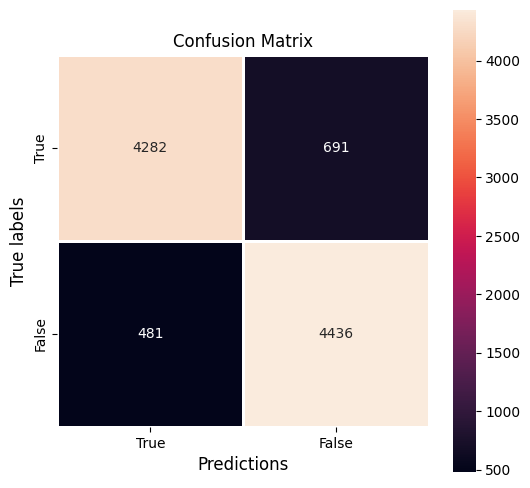

In [18]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Confusion Matrix', size=12);
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

In [23]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('/content/drive/MyDrive/DT-NLP-2024/Lesson8/test_feat_clean.csv',
                          usecols=['clean_review', 'label'])
test_dataset = test_dataset.dropna(subset=['clean_review'])
# Change columns order
test_dataset = test_dataset[['clean_review', 'label']]

In [24]:
test_dataset.head()

,clean_review,label
3,episode potential basic premise woman living d...,0
5,spaceship returns mars couple months earlier p...,0
9,movie years end civil war likely anticipation ...,1
10,totally honest expecting going souls reading h...,1
12,terrible people away things overrated things h...,0


In [25]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
17217/47694 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 189
Mapped words to indices
Batches created


In [26]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.880. Test error: 0.071


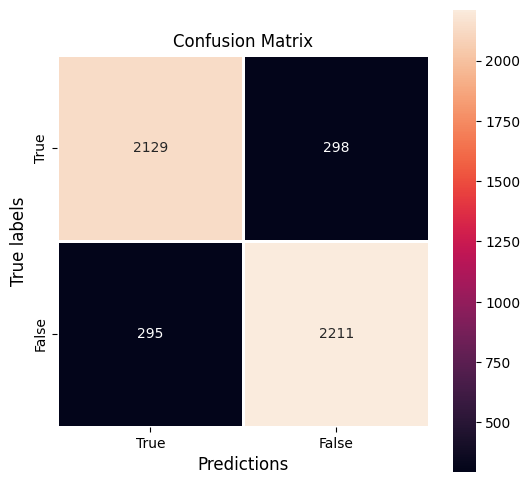

In [28]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Confusion Matrix', size=12);
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()